In [19]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from collections import Counter
import torch
import numpy as np
from PIL import Image
import seaborn as sns


from torchvision.io import read_image
from torch.utils.data import Subset
import random


import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [20]:
train_dir = "../dataset/train"

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(train_dir, transform=transform)

print(f"Classes: {dataset.classes}")
print(f"Total samples: {len(dataset)}")


Classes: ['apple', 'banana']
Total samples: 158


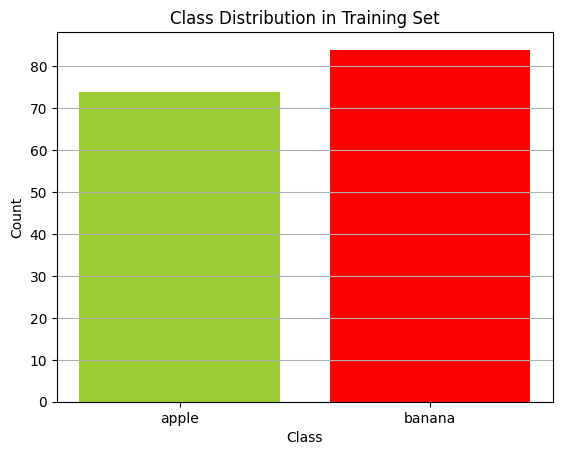

In [21]:
labels = [label for _, label in dataset]
counts = Counter(labels)

plt.bar(dataset.classes, [counts[i] for i in range(len(dataset.classes))], color=['yellowgreen', 'red'])
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()

In [22]:
shapes = [img[0].shape for img in dataset]
unique_shapes = set(shapes)

print(f"Unique image shapes found: {unique_shapes}")


Unique image shapes found: {torch.Size([3, 128, 128])}


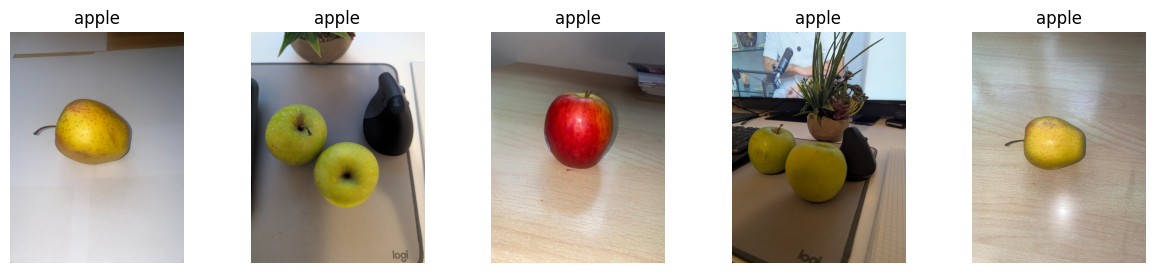

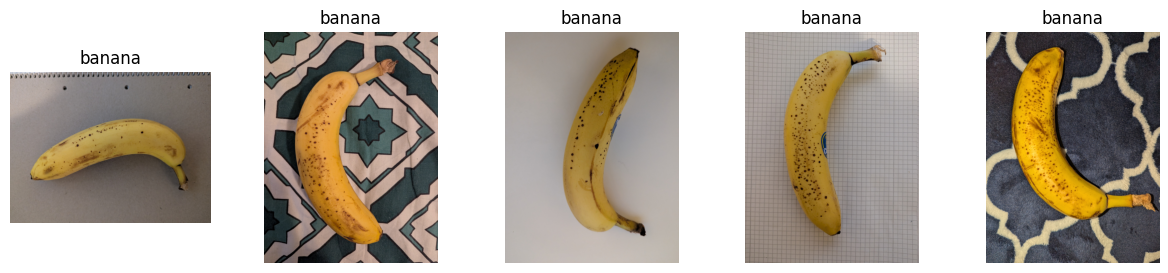

In [23]:
def show_class_samples(class_name, num_images=5):
    class_path = os.path.join(train_dir, class_name)
    files = random.sample(os.listdir(class_path), num_images)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, file in enumerate(files):
        img_path = os.path.join(class_path, file)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(class_name)
    plt.show()

show_class_samples("apple")
show_class_samples("banana")

In [24]:
class BananaOrAppleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x64x64

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32x32

            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.model(x)


In [25]:
model = BananaOrAppleClassifier()
model.load_state_dict(torch.load("../../hf_app/banana_or_apple.pt", map_location="cpu"))
model.eval()

BananaOrAppleClassifier(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=32768, out_features=128, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [26]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_dataset = datasets.ImageFolder("../../training/dataset/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

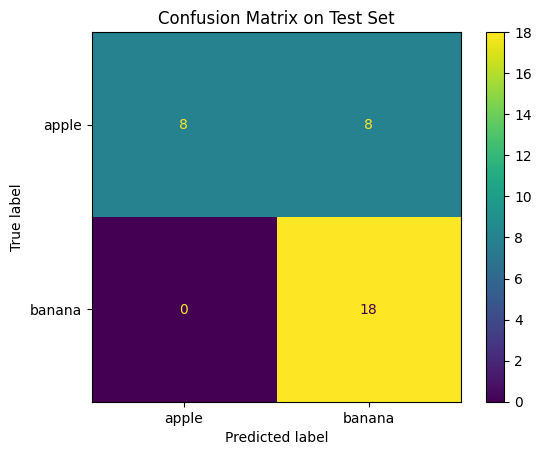

In [27]:
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        preds = model(imgs).argmax(dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot()
plt.title("Confusion Matrix on Test Set")
plt.show()